In [1]:
import pint
import os, sys
from utils import *

lib_path = get_project_root()
sys.path.insert(0, lib_path)

from lib.calculator import LinkBudgetCalculator

In [2]:
ureg = pint.UnitRegistry()

# create the linkBudgetCalculator object
lb_calc = LinkBudgetCalculator(ureg)

## Analysis of Design Iteration X

### Description

<br>
TEMPLATE <br>
DESCRIPTION <br>
FOR <br>
DESIGNS <br>
<br>

![alt text](block_diagram_template.png "Block Diagram")
*<p style="text-align: center;">Block Diagram</p>*


### Setup of Ground Station Values

DESCRIBE PARAMETERS OF GROUND STATION

Values for specific ground station are below:

In [3]:
lb_calc.altitude_ground_station   =  400 * ureg.meter
lb_calc.implementation_loss       = -1.0   # dB
lb_calc.polarization_losses       =  0.0   # dB
lb_calc.receive_antenna_gain      =  5.4   # dB
lb_calc.system_noise_figure       =  5.0   # dB

### Setup of Satellite Values

Values stated for a certain NOAA satellite. These values are covered in the documentation.

In [4]:
lb_calc.altitude_satellite        =  860 * ureg.kilometer
lb_calc.transmit_power            =  5.0 * ureg.watt
lb_calc.transmit_losses           = -1.0   # dB
lb_calc.transmit_antenna_gain     =  4.0   # dBi

### Setup of Additional Values

Create functions for the changing elevation angle and atmospheric loss values.

In [5]:
# receive pointing loss for given elevation (at our frequency)
# these values are different for each antenna system, so the values are defined here for clarity
# see referenced antenna specifications for more information
def rx_pointing_loss_at_elev(elev):
    return -10.0 if elev < 5  * ureg.degrees else \
           -6.0  if elev < 20 * ureg.degrees else \
           -3.0  if elev < 35 * ureg.degrees else \
           -1.0  if elev < 50 * ureg.degrees else 0.0

Set paramaters for the analysis here

Additional values are needed for the channel characteristics. A few of these values will change during an orbital pass!

In [6]:
lb_calc.orbit_elevation_angle     =  0.001          * ureg.degrees
lb_calc.downlink_frequency        =  137.5          * ureg.megahertz
lb_calc.target_energy_noise_ratio =  20.0             # dB
lb_calc.noise_bandwidth           =  34.0           * ureg.kilohertz
lb_calc.transmit_pointing_loss    = -3.0              # dB
lb_calc.atmospheric_loss          =  atmloss_at_elev(ureg, lb_calc.orbit_elevation_angle)
lb_calc.receiving_pointing_loss   =  rx_pointing_loss_at_elev(lb_calc.orbit_elevation_angle)

### Analysis

Define variables for running a sweep over an orbital pass.

Increment through an entire orbital pass.

In [56]:
# get the elevation angles of a particular pass on X date
# poor pass
results = compute_angles('2018/04/01 18:00.00')
# average pass
#results = compute_angles('2018/04/01 04:00.00')
# excellent pass
#results = compute_angles('2018/04/01 14:00.00')

outputs = []

# DEBUG
temp = []

for i, angle in enumerate(results[1]):
    # compute the budget
    lb_calc.run()
    
    # ensure the computation was valid
    if not lb_calc.is_valid:
        raise Exception('Run at elevation angle ', lb_calc.orbit_elevation_angle, ' was not valid')
    
    # save output as a tuple to output list
    outputs.append( (lb_calc.link_distance, \
                     lb_calc.downlink_path_loss, \
                     lb_calc.received_power, \
                     lb_calc.energy_noise_ratio, \
                     lb_calc.link_margin) )
    
    # increment the elevation angle
    lb_calc.orbit_elevation_angle     = angle * ureg.degrees
    lb_calc.atmospheric_loss          = atmloss_at_elev(ureg, lb_calc.orbit_elevation_angle)
    lb_calc.receiving_pointing_loss   = rx_pointing_loss_at_elev(lb_calc.orbit_elevation_angle)

print('Max elevation angle: {}'.format(max(results[1])))
print('Duration of pass: {}'.format(results[2][-1] - results[2][0]))

Max elevation angle: 19.35832705132524
Duration of pass: 0:14:23.999633


Once analysis has run, examine the results.

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

# extract lists of the variables
distances = [ i[0].magnitude for i in outputs ]
loss      = [ i[1] for i in outputs ]
rx_pow    = [ i[2] for i in outputs ]
eb_no     = [ i[3] for i in outputs ]
margins   = [ i[4] for i in outputs ]

# removing the last value which was zero for some reason
angles = results[1]
margins = margins[:-1]

Duration for link above margin: 0 seconds (0.0 minutes)


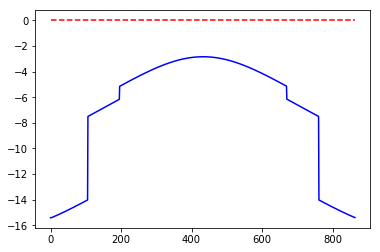

In [58]:
plt.plot(range(0, len(margins)), margins, 'b', range(0, len(margins)), [0] * len(margins), 'r--')
#plt.plot(angles, margins, 'b')

total_s = 0
for m in margins:
    if m > 0:
        total_s += 1

print('Duration for link above margin: {} seconds ({:.3} minutes)'.format(total_s, total_s/60))

### Conclusions

DETAIL CONCLUSIONS FOR THIS ITERATION

PROBABLY WILL VARY GREATLY FOR EACH ITERATION